# Load

In [163]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [164]:
# --- Configuration (เหมือนเดิม) ---
SEQUENCE_LENGTH = 30
crit_thresh = 3.277077
warn_thresh = 1.464656
#crit_thresh = 1.308508
#warn_thresh= 0.807623

numerical_cols = ['soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean']
label_order = ['Critical', 'Warning', 'Normal']
PREDICTION_HORIZON = 0 # กำหนด prediction horizon เอง

# --- Load Model & Scaler (เหมือนเดิม) ---
try:
    scaler = joblib.load('scaler.save')
    model = load_model('lstm_autoencoder_model.h5', compile=False)
    print("LSTM Autoencoder model and scaler loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Make sure 'scaler.save' and 'lstm_autoencoder_model.h5' are in the correct directory.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during model loading: {e}")
    exit()

LSTM Autoencoder model and scaler loaded successfully.


In [165]:
# --- Load and Preprocess Data (No Labels Needed) ---
df1 = pd.read_csv("./../../data/dev101_resample1T.csv")
df2 = pd.read_csv("./../../data/dev102_resample1T.csv")

# Concatenate dataframes and preprocess timestamps
df_raw = pd.concat([df1, df2], ignore_index=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
df_raw = df_raw.sort_values('timestamp').reset_index(drop=True)

# --------------------------------------------------------------------------
# แก้ไข/เพิ่ม: การจัดการคอลัมน์ 'label' เพื่อใช้เป็น True Labels
# --------------------------------------------------------------------------
# ตรวจสอบว่าคอลัมน์ 'label' มีอยู่หรือไม่
if 'label' not in df_raw.columns:
    print("Warning: 'label' column not found in raw data. Evaluation metrics might not be accurate.")
    # ถ้าไม่มี label ให้สร้างคอลัมน์ label ที่เป็น 'Normal' ทั้งหมด
    df_raw['label'] = 'Normal'
else:
    # เติมค่า NaN ในคอลัมน์ 'label' ด้วย 'Normal'
    df_raw['label'] = df_raw['label'].fillna('Normal')
    # ปรับปรุงชื่อ label ให้เป็นรูปแบบที่ต้องการ (e.g., 'critical' -> 'Critical')
    df_raw['label'] = df_raw['label'].replace({
        'critical': 'Critical',
        'normal': 'Normal',
        'Normal': 'Normal', # ensure consistency
        'warning': 'Warning'
    })
# --------------------------------------------------------------------------


print(f"\nLoaded {len(df_raw)} data points from dataset.")
print("\nDataFrame Description:")
print(df_raw.describe())

# Check for missing numerical columns
if not all(col in df_raw.columns for col in numerical_cols):
    missing_cols = [col for col in numerical_cols if col not in df_raw.columns]
    print(f"Error: Missing numerical columns in DataFrame: {missing_cols}")
    print("Please check your CSV files and 'numerical_cols' definition.")
    exit()

# Scale the numerical features using the loaded scaler
X_scaled = scaler.transform(df_raw[numerical_cols])

# Create a copy for sequence creation with scaled features
df_scaled_for_sequences = df_raw.copy()
for i, col in enumerate(numerical_cols):
    df_scaled_for_sequences[f'scaled_{col}'] = X_scaled[:, i]
    

print("\nData preprocessing complete.")


Loaded 63169 data points from dataset.

DataFrame Description:
                           timestamp         devID     soil_mean  \
count                          63169  63169.000000  63169.000000   
mean   2025-06-04 17:58:38.360904960    101.510599     48.409481   
min              2025-05-02 11:42:00    101.000000     21.100000   
25%              2025-05-29 11:56:00    101.000000     43.099998   
50%              2025-06-11 03:14:00    102.000000     49.799999   
75%              2025-06-18 05:41:00    102.000000     57.700001   
max              2025-06-29 20:26:00    102.000000     66.440001   
std                              NaN      0.499892     10.553187   

          rain_mean     temp_mean     humi_mean      geo_mean  
count  63169.000000  63169.000000  63169.000000  63169.000000  
mean       0.206829     29.815305     75.378183      8.012693  
min        0.000000     24.321737     44.830344      0.000000  
25%        0.000000     27.324257     69.750740      3.903331  
50%

In [166]:
df_raw

,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,label
0,2025-05-02 11:42:00,101,28.839999,0.0,34.233463,63.098955,14.622758,Normal
1,2025-05-02 11:42:00,102,22.200001,0.0,34.478334,61.378755,8.284870,Normal
2,2025-05-02 11:43:00,102,22.200001,0.0,34.318556,62.127083,6.897215,Normal
3,2025-05-02 11:43:00,101,28.816666,0.0,34.047519,63.319192,10.538904,Normal
4,2025-05-02 11:44:00,101,28.799999,0.0,34.081788,63.662011,9.419168,Normal
...,...,...,...,...,...,...,...,...
63164,2025-06-29 20:22:00,102,25.600000,0.0,29.749448,79.173190,3.721589,Normal
63165,2025-06-29 20:23:00,102,25.600000,0.0,29.807662,78.605556,9.840936,Normal
63166,2025-06-29 20:24:00,102,25.600000,0.0,29.561457,79.165944,9.186358,Normal
63167,2025-06-29 20:25:00,102,25.600000,0.0,29.950789,77.049133,3.266326,Normal


In [167]:
# --- Create Sequences and Calculate Anomaly Scores ---
def create_sequences_by_device(df, sequence_length, numerical_cols, return_index=False):
    sequences = []
    device_ids = []
    timestamps = []
    last_indices = []
    groupby_obj = df.groupby('devID')
    scaled_numerical_cols = [f'scaled_{col}' for col in numerical_cols]
    if not all(col in df.columns for col in scaled_numerical_cols):
        raise ValueError(f"Missing scaled feature columns in DataFrame: {scaled_numerical_cols}")

    for dev_id, group in groupby_obj:
        group = group.sort_values('timestamp')
        values = group[scaled_numerical_cols].values
        time_vals = group['timestamp'].values
        idx_vals = group.index.values

        if len(values) >= sequence_length:
            for i in range(len(values) - sequence_length + 1):
                sequences.append(values[i:i + sequence_length])
                device_ids.append(dev_id)
                timestamps.append(time_vals[i + sequence_length - 1])
                if return_index:
                    last_indices.append(idx_vals[i + sequence_length - 1])
    if return_index:
        return np.array(sequences), device_ids, timestamps, last_indices
    else:
        return np.array(sequences), device_ids, timestamps

X_seq, device_ids, seq_timestamps, original_indices = \
    create_sequences_by_device(df_scaled_for_sequences, SEQUENCE_LENGTH, numerical_cols, return_index=True)

if len(X_seq) == 0:
    print("Error: No sequences formed from the dataset. Check SEQUENCE_LENGTH or data.")
    exit()

reconstructed_sequences = model.predict(X_seq, verbose=0)

In [168]:
# --- Calculate Reconstruction Error for PCA (element-wise squared error) ---
X_error_full = np.square(X_seq - reconstructed_sequences)
num_samples = X_error_full.shape[0]
pca_input_error = X_error_full.reshape(num_samples, -1)

# --- Reduce dimensionality with PCA ---
pca_error = PCA(n_components=2)
X_pca_error = pca_error.fit_transform(pca_input_error)

# Calculate anomaly score (Mean Squared Error per sequence)
errors = np.mean(np.square(X_seq - reconstructed_sequences), axis=(1, 2))

# Create df_seq_results directly after calculating errors and having original_indices
df_seq_results = pd.DataFrame({
    'original_index': original_indices,
    'devID_seq': device_ids, # Keep devID for later grouping
    'timestamp_seq': seq_timestamps,
    'anomaly_score': errors
})

In [169]:
# --- Apply Prediction Horizon and Classify Risk ---
def classify_risk(score):
    if score > crit_thresh:
        return "Critical"
    elif score > warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_processed = df_raw.copy()
df_processed = df_processed.merge(df_seq_results[['original_index', 'anomaly_score']],
                                 left_index=True, right_on='original_index', how='left')
df_processed.drop(columns=['original_index'], inplace=True)

# Check if 'devID' exists BEFORE groupby
if 'devID' not in df_processed.columns:
    print("Error: 'devID' column not found in df_processed after merge. Check data loading or merge logic.")
    exit()

# Shift the anomaly scores FORWARD by the PREDICTION_HORIZON
df_processed['anomaly_score_shifted_for_prediction'] = df_processed.groupby('devID')['anomaly_score'].shift(PREDICTION_HORIZON)
df_processed['predicted_risk'] = df_processed['anomaly_score_shifted_for_prediction'].apply(classify_risk)

# Include the true 'label' from df_raw into df_processed
# Since PREDICTION_HORIZON is 0, the 'label' from df_raw should align directly with predicted_risk
df_processed['true_label'] = df_raw['label'] # Assuming df_raw and df_processed align by index
df_processed['anomaly_score'] = df_processed['anomaly_score'].fillna(0)

df_final_for_analysis = df_processed.dropna(subset=['anomaly_score_shifted_for_prediction', 'predicted_risk', 'true_label']).copy()



In [170]:
# --- Prepare data for PCA plotting (linking PCA results to shifted risk) ---
# df_pca_viz needs devID
df_pca_viz = pd.DataFrame(X_pca_error, columns=['PC1', 'PC2'])
df_pca_viz['original_index'] = original_indices
df_pca_viz['devID'] = device_ids # Add devID here, directly from the source of original_indices

# Create a temporary DataFrame to hold the 'predicted_risk' from df_final_for_analysis
temp_df_for_risk_mapping = df_final_for_analysis[['devID', 'predicted_risk']].copy() # Ensure devID is here
temp_df_for_risk_mapping['target_index'] = temp_df_for_risk_mapping.index # The index where the prediction applies
temp_df_for_risk_mapping['source_index'] = temp_df_for_risk_mapping['target_index'] - PREDICTION_HORIZON

# Now, merge df_pca_viz (which has 'original_index' as the source) with this mapping.
df_pca_ready = df_pca_viz.merge(
    temp_df_for_risk_mapping,
    left_on=['original_index', 'devID'], # Keys from df_pca_viz
    right_on=['source_index', 'devID'],  # Keys from temp_df_for_risk_mapping
    how='inner'
)

df_pca_ready = df_pca_ready.dropna(subset=['PC1', 'PC2', 'predicted_risk']).copy()

custom_palette = {
    'Normal': 'green',
    'Warning': 'orange',
    'Critical': 'red'
}


--- PCA Components Loadings on Original Scaled Features ---
                PC1       PC2
temp_mean  0.684820  0.122974
geo_mean  -0.018221  0.691094
rain_mean -0.137172  0.556345
soil_mean -0.242124  0.416183
humi_mean -0.673238 -0.156647
----------------------------------------------------------------------


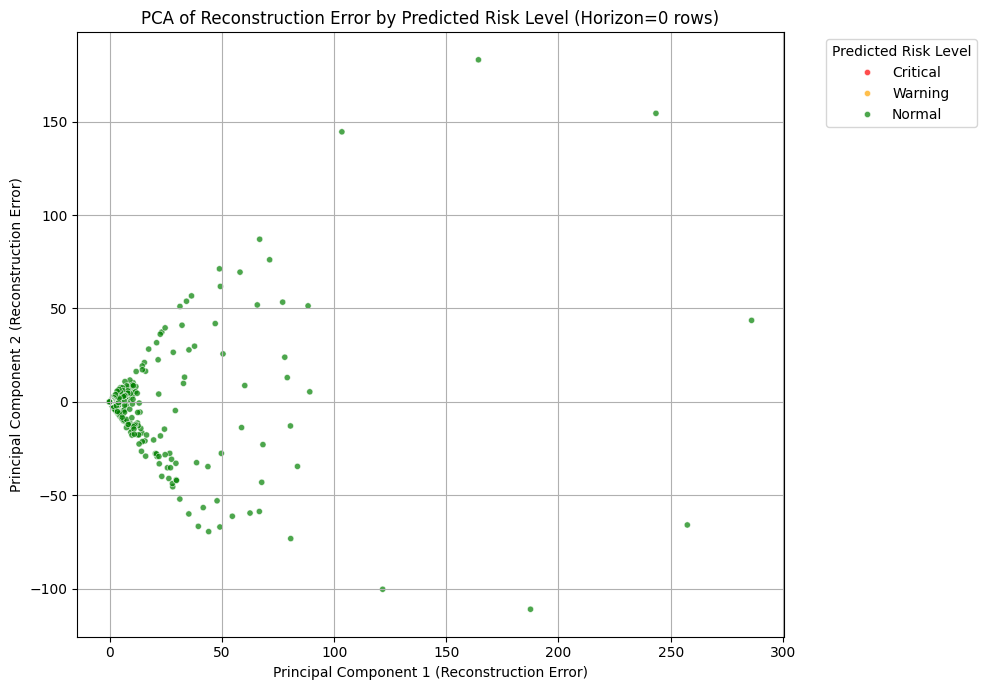

PCA visualization of Reconstruction Error completed.


In [171]:
print("\n--- PCA Components Loadings on Original Scaled Features ---")

# สร้าง PCA model ใหม่สำหรับข้อมูล features ตั้งต้น
# หากคุณต้องการวิเคราะห์ PCA ของข้อมูลตั้งต้น (ไม่ใช่อนุพันธ์ของ reconstruction error)
# ต้องรัน PCA บน X_scaled (ซึ่งเป็นข้อมูล features ที่ปรับขนาดแล้ว)
pca_features = PCA(n_components=2)
X_pca_features = pca_features.fit_transform(X_scaled)

# สร้าง DataFrame เพื่อแสดง Components Loadings
# ตอนนี้ columns=numerical_cols จะถูกต้อง เพราะ X_scaled มีแค่ 5 คอลัมน์ตามชื่อฟีเจอร์
pca_df_features = pd.DataFrame(pca_features.components_, columns=numerical_cols, index=["PC1", "PC2"])

# Transpose และเรียงลำดับตาม PC1 เพื่อให้เห็นการมีส่วนร่วมของแต่ละฟีเจอร์
print(pca_df_features.T.sort_values("PC1", ascending=False))
print("-" * 70)
# --------------------------------------------------------------------------


# --- Plotting PCA ---
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca_ready, x='PC1', y='PC2', hue='predicted_risk',
                palette=custom_palette, alpha=0.7, s=20, edgecolor='w', linewidth=0.5,
                hue_order=label_order)
plt.title(f"PCA of Reconstruction Error by Predicted Risk Level (Horizon={PREDICTION_HORIZON} rows)")
plt.xlabel("Principal Component 1 (Reconstruction Error)")
plt.ylabel("Principal Component 2 (Reconstruction Error)")
plt.grid(True)
plt.legend(title='Predicted Risk Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print("PCA visualization of Reconstruction Error completed.")

# Describe

In [172]:
normal_group = df_final_for_analysis[df_final_for_analysis['predicted_risk'] == "Normal"]
print("normal_group")
print(normal_group[numerical_cols].describe())

normal_group
          soil_mean     rain_mean     temp_mean     humi_mean      geo_mean
count  63005.000000  63005.000000  63005.000000  63005.000000  63005.000000
mean      48.418687      0.195367     29.815894     75.380371      8.001858
std       10.538623      1.711182      3.174358      8.426916      5.006458
min       21.100000      0.000000     24.321737     44.830344      0.000000
25%       43.099998      0.000000     27.326390     69.769815      3.903155
50%       49.780000      0.000000     28.424965     79.597011      7.352630
75%       57.700001      0.000000     32.620672     81.419699     11.526810
max       66.440001     39.116001     38.939561     86.716682     32.043915


In [173]:
warning_group = df_final_for_analysis[df_final_for_analysis['predicted_risk'] == "Warning"]
print("warning_group")
print(warning_group[numerical_cols].describe())

warning_group
       soil_mean  rain_mean  temp_mean  humi_mean   geo_mean
count  93.000000  93.000000  93.000000  93.000000  93.000000
mean   55.650215   5.886527  26.681565  81.142389  12.540178
std     3.549233   8.427403   0.559732   0.665457   6.388263
min    50.700000   0.000000  25.753033  80.085298   3.329615
25%    52.900000   0.000000  26.209658  80.686885   5.834405
50%    55.099998   1.862667  26.584574  80.915770  14.643292
75%    56.700001   9.834880  26.925307  81.586787  17.456105
max    64.239999  40.513000  27.887159  82.718243  23.678365


In [174]:
critical_group = df_final_for_analysis[df_final_for_analysis['predicted_risk'] == "Critical"]
print("critical_group")
print(critical_group[numerical_cols].describe())

critical_group
       soil_mean  rain_mean  temp_mean  humi_mean   geo_mean
count  13.000000  13.000000  13.000000  13.000000  13.000000
mean   54.239103  16.050456  26.189262  81.367336  18.771045
std     1.998532   1.441535   0.453371   0.761501   3.073335
min    50.620000  14.137640  25.710975  80.257344  14.636246
25%    52.375000  15.506700  25.840086  80.786069  15.898906
50%    55.400002  15.646400  25.969330  81.364577  18.003582
75%    55.599998  15.646400  26.789120  82.065540  20.773781
max    55.719999  19.502121  26.841993  82.423649  24.436731


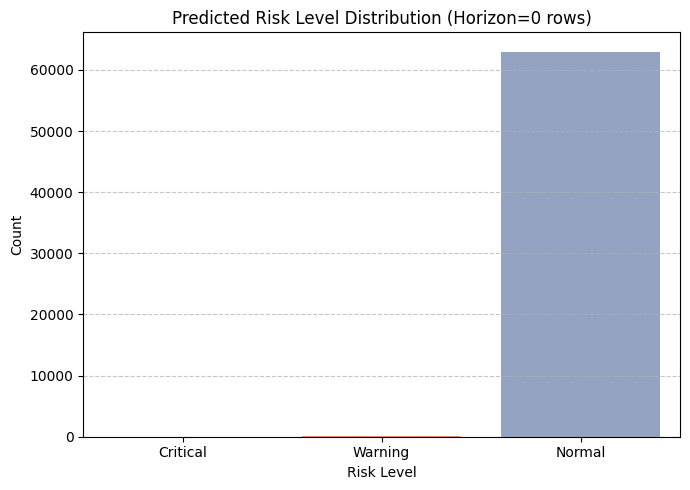

In [175]:
# Plot 1: Predicted Risk Level Distribution
plt.figure(figsize=(7, 5))
sns.countplot(data=df_final_for_analysis, x='predicted_risk', order=label_order, palette='Set2')
plt.title(f'Predicted Risk Level Distribution (Horizon={PREDICTION_HORIZON} rows)')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Distribution of Anomaly Scores

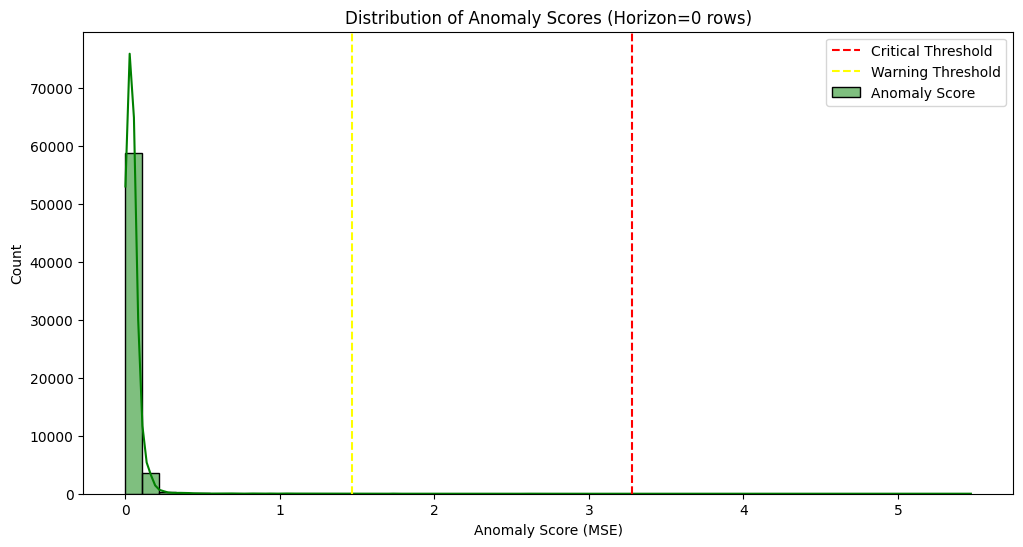

In [176]:
# Plot 2: Anomaly Score Distribution with Thresholds
plt.figure(figsize=(12, 6))
sns.histplot(df_final_for_analysis['anomaly_score_shifted_for_prediction'], bins=50, kde=True, color='green', label='Anomaly Score')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title(f'Distribution of Anomaly Scores (Horizon={PREDICTION_HORIZON} rows)')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.show()

# histogram


Generating KDE plots for numerical features by predicted risk levels...


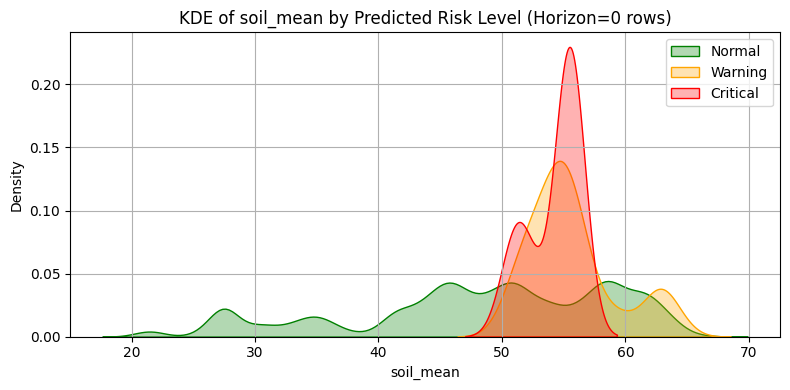

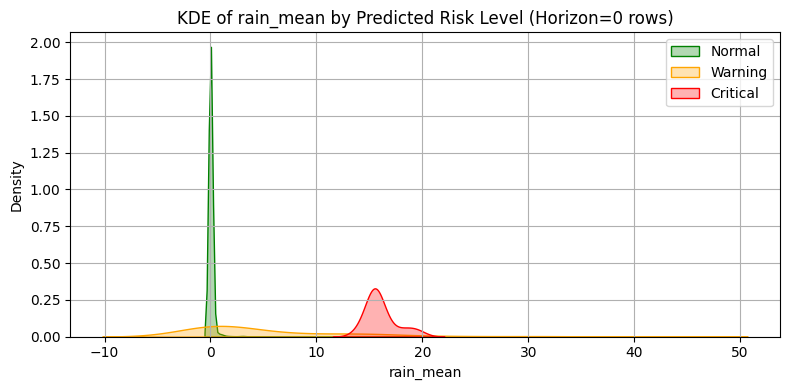

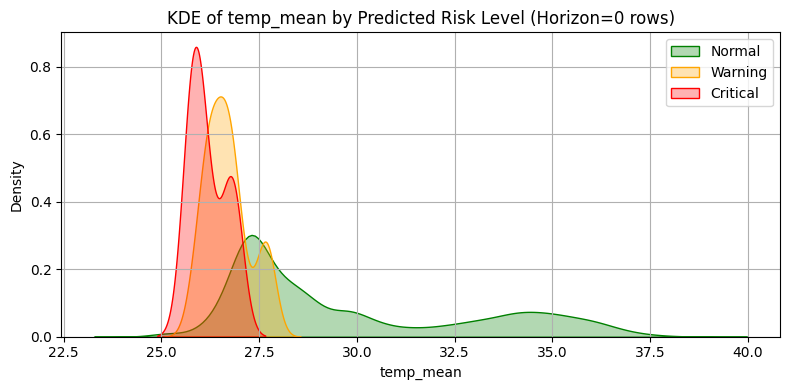

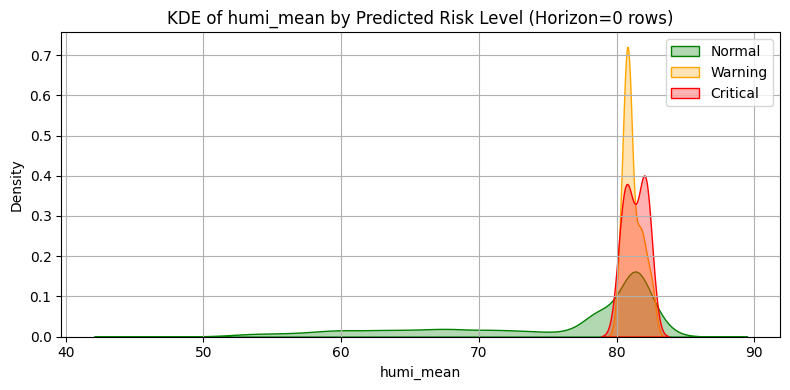

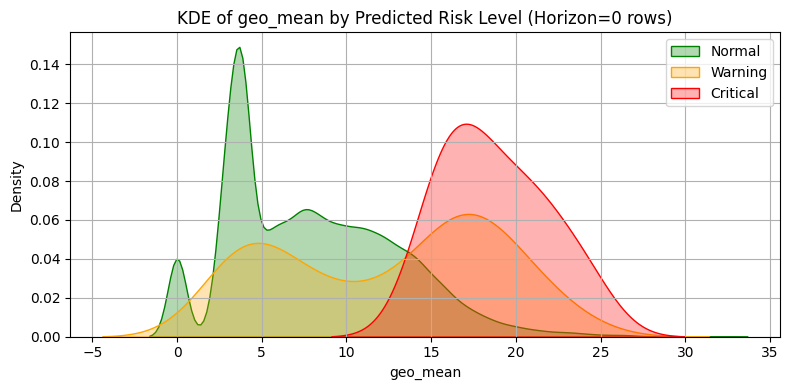

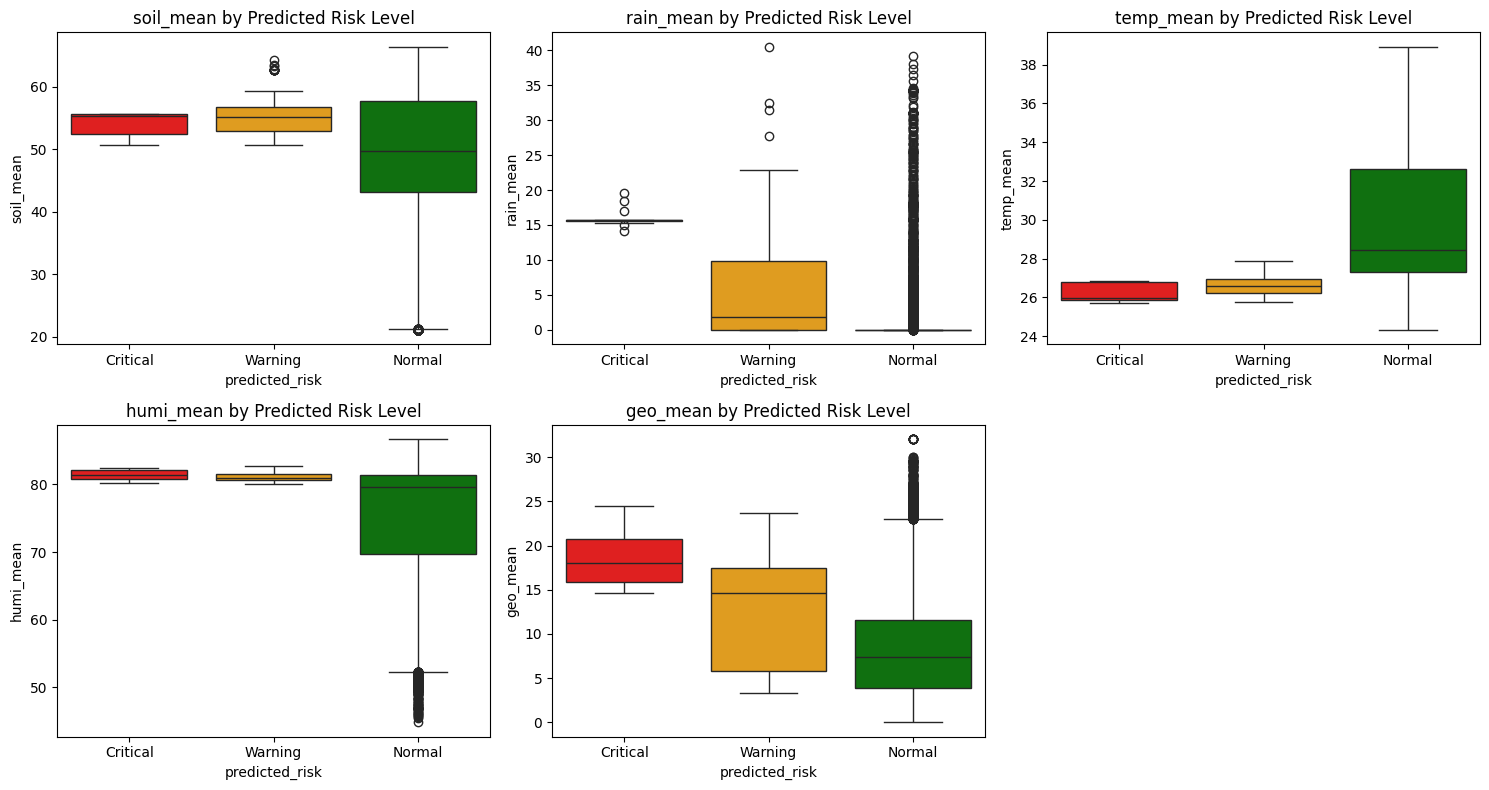

In [177]:
# --- KDE Plots for each numerical column by Predicted Risk ---
print("\nGenerating KDE plots for numerical features by predicted risk levels...")
# For KDE plots and box plots, we want to see the distribution of the *actual* numerical
# values that correspond to the *predicted* risk level at that timestamp.
# `df_final_for_analysis` is suitable for this, as it contains both the original numerical
# columns and the `predicted_risk` for the corresponding timestamp.

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    # Filter for each risk level and plot KDE
    sns.kdeplot(df_final_for_analysis[df_final_for_analysis['predicted_risk'] == 'Normal'][col], label='Normal', color=custom_palette['Normal'], fill=True, alpha=0.3)
    sns.kdeplot(df_final_for_analysis[df_final_for_analysis['predicted_risk'] == 'Warning'][col], label='Warning', color=custom_palette['Warning'], fill=True, alpha=0.3)
    sns.kdeplot(df_final_for_analysis[df_final_for_analysis['predicted_risk'] == 'Critical'][col], label='Critical', color=custom_palette['Critical'], fill=True, alpha=0.3)
    plt.title(f"KDE of {col} by Predicted Risk Level (Horizon={PREDICTION_HORIZON} rows)")
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Box plots for numerical columns by Predicted Risk
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_final_for_analysis,
        order=label_order,
        palette=custom_palette # Use the consistent palette
    )
    plt.title(f'{col} by Predicted Risk Level')
plt.tight_layout()
plt.show()

## Time Series

In [178]:
df_final_for_analysis['timestamp'].min()

Timestamp('2025-05-02 12:11:00')

In [179]:
df_final_for_analysis['timestamp'].max()

Timestamp('2025-06-29 20:26:00')

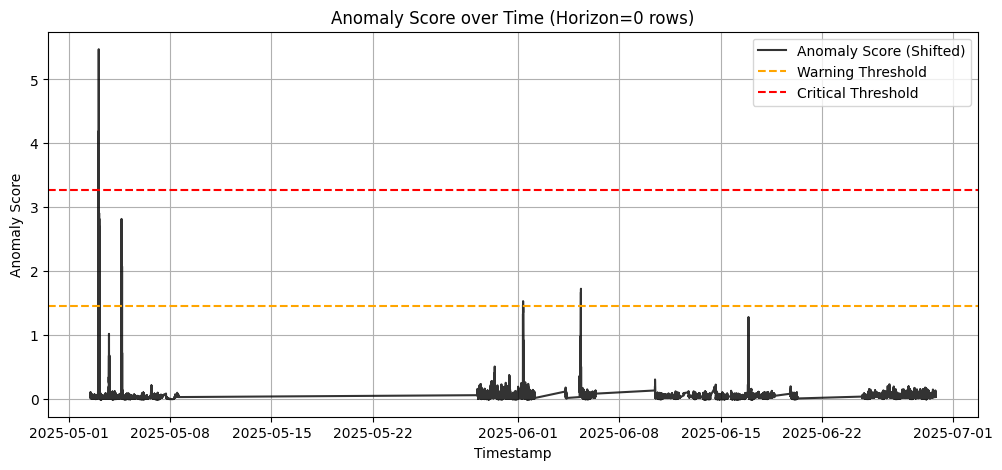

In [180]:
# --- Anomaly Score over Time ---
# Use df_final_for_analysis for this, as it already has the shifted anomaly scores
if 'timestamp' in df_final_for_analysis.columns:
    df_sorted_for_plot = df_final_for_analysis.sort_values('timestamp')
    plt.figure(figsize=(12,5))
    plt.plot(df_sorted_for_plot['timestamp'], df_sorted_for_plot['anomaly_score_shifted_for_prediction'], color='black', label='Anomaly Score (Shifted)', alpha=0.8)
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning Threshold')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
    plt.title(f'Anomaly Score over Time (Horizon={PREDICTION_HORIZON} rows)')
    plt.xlabel('Timestamp')
    plt.ylabel('Anomaly Score')
    plt.legend()
    plt.grid(True)
    plt.show()

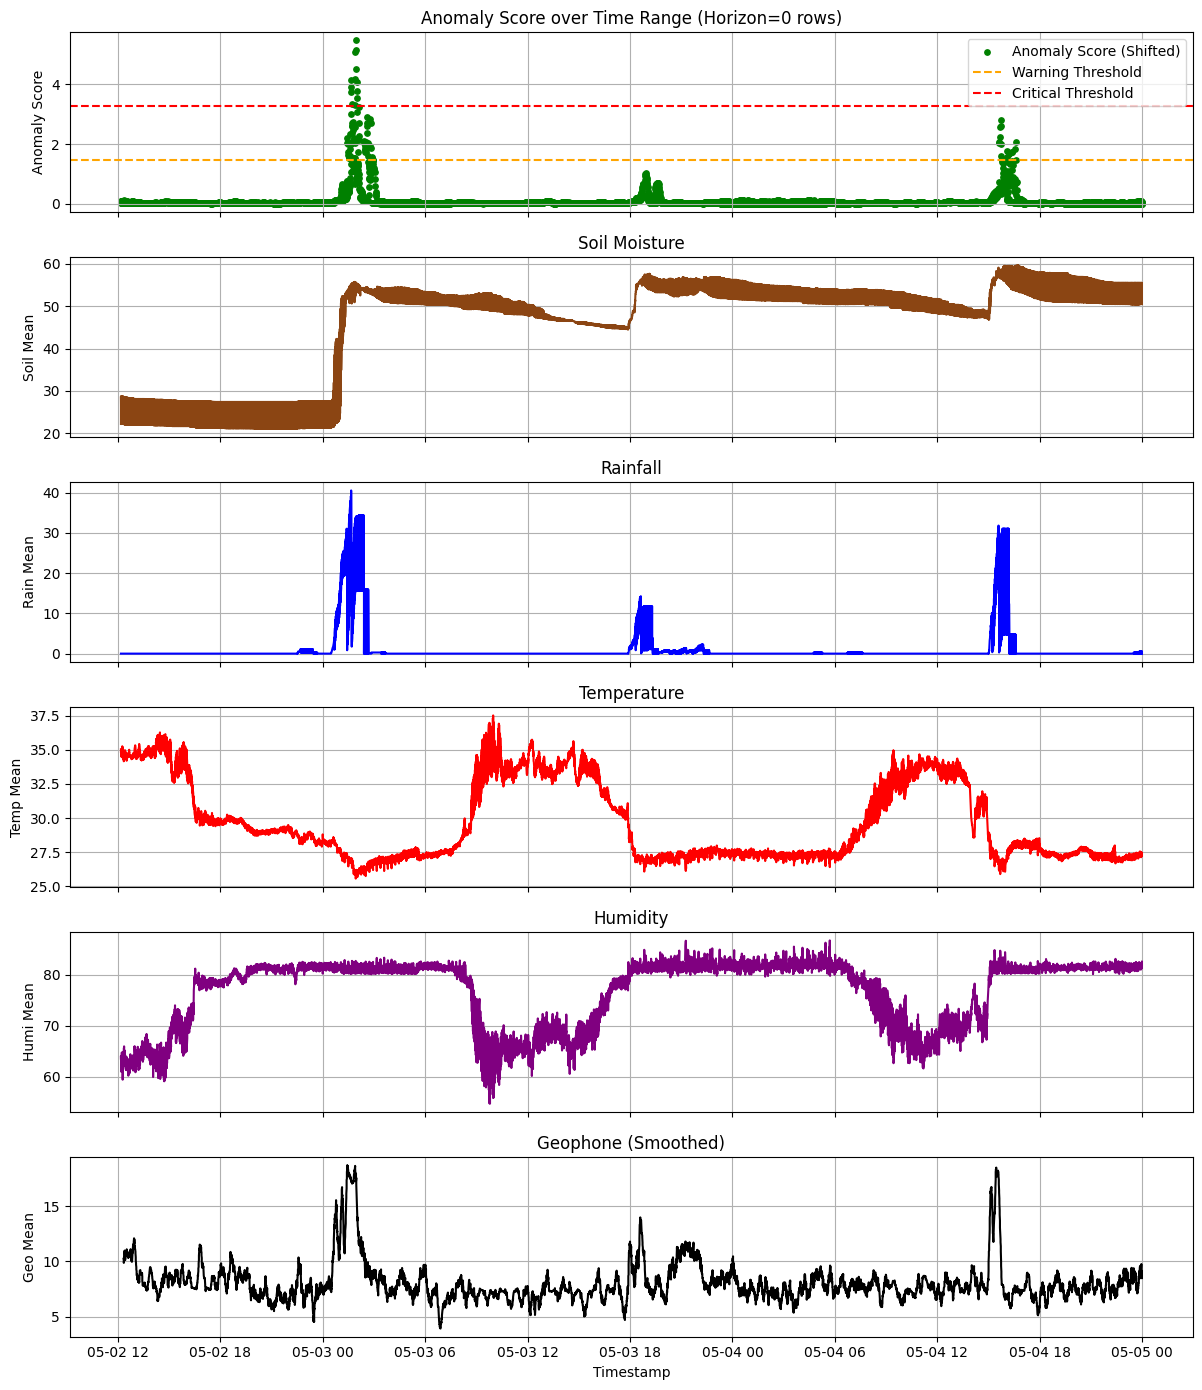

In [181]:
# --- Detailed Time Series Plot for a Specific Range ---
df_dev_time_series = df_final_for_analysis.set_index('timestamp').sort_index()
# Define a specific date range (adjust as per your data's timestamps)
time_series_start = "2025-05-02"
time_series_end = "2025-05-04"
df_range = df_dev_time_series.loc[time_series_start:time_series_end].copy()
if not df_range.empty:
    fig, axs = plt.subplots(6, 1, figsize=(12, 14), sharex=True) # Increased height for better visibility
    # Plot 1: Anomaly Score
    axs[0].scatter(df_range.index, df_range['anomaly_score_shifted_for_prediction'], color='green', s=15, label='Anomaly Score (Shifted)')
    axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning Threshold')
    axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical Threshold')
    axs[0].set_ylabel("Anomaly Score")
    axs[0].set_title(f"Anomaly Score over Time Range (Horizon={PREDICTION_HORIZON} rows)")
    axs[0].legend(loc='upper right')
    axs[0].grid(True)
    # Plot 2-5: Numerical columns
    axs[1].plot(df_range.index, df_range['soil_mean'], color='saddlebrown')
    axs[1].set_ylabel("Soil Mean")
    axs[1].set_title("Soil Moisture")
    axs[1].grid(True)
    axs[2].plot(df_range.index, df_range['rain_mean'], color='blue')
    axs[2].set_ylabel("Rain Mean")
    axs[2].set_title("Rainfall")
    axs[2].grid(True)
    axs[3].plot(df_range.index, df_range['temp_mean'], color='red')
    axs[3].set_ylabel("Temp Mean")
    axs[3].set_title("Temperature")
    axs[3].grid(True)
    axs[4].plot(df_range.index, df_range['humi_mean'], color='purple')
    axs[4].set_ylabel("Humi Mean")
    axs[4].set_title("Humidity")
    axs[4].grid(True)
    # Plot 6: Smoothed Geophone
    window_size = 20 # Adjust as needed
    smoothed_geo = df_range['geo_mean'].rolling(window=window_size).mean()
    axs[5].plot(df_range.index, smoothed_geo, color='black')
    axs[5].set_ylabel("Geo Mean")
    axs[5].set_title("Geophone (Smoothed)")
    axs[5].grid(True)
    plt.xlabel("Timestamp")
    plt.tight_layout()
    plt.show()
else:
    print(f"\nWarning: The specified date range '{time_series_start}' to '{time_series_end}' for detailed time series plot is empty. Please check your data's timestamps.")


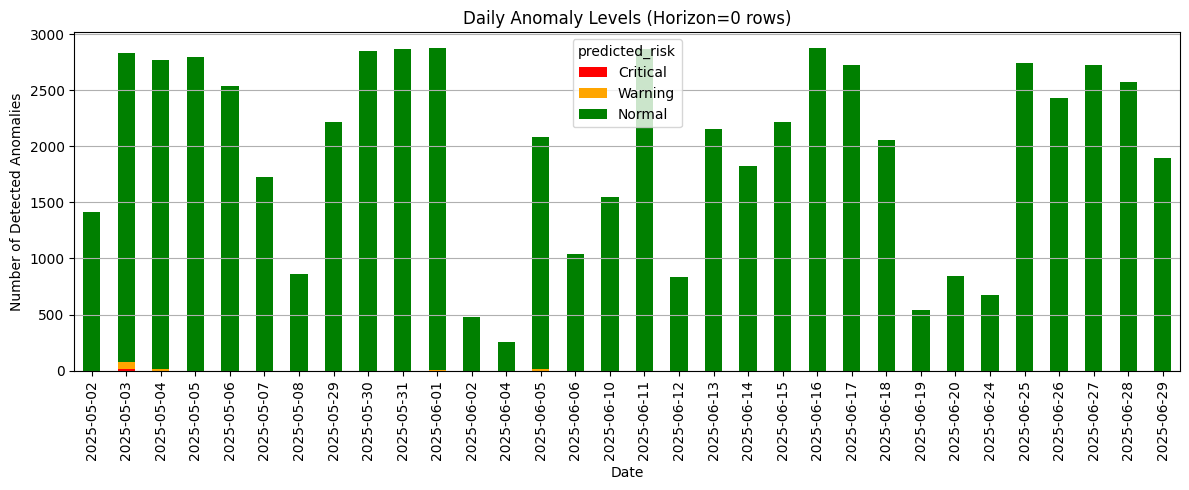

In [182]:
# --- Daily Anomaly Levels ---
df_results_daily = df_final_for_analysis.copy()
df_results_daily['date'] = pd.to_datetime(df_results_daily['timestamp']).dt.date
# Group by date and predicted_risk to count daily alerts
alerts_per_day = df_results_daily.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)
# Ensure all risk levels are present in columns, fill with 0 if not
for risk in label_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0
alerts_per_day = alerts_per_day[label_order] # Reorder columns as per label_order
colors_for_bars = [custom_palette.get(risk, 'gray') for risk in label_order] # Get colors from custom_palette
alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors_for_bars)
plt.title(f"Daily Anomaly Levels (Horizon={PREDICTION_HORIZON} rows)")
plt.xlabel("Date")
plt.ylabel("Number of Detected Anomalies")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

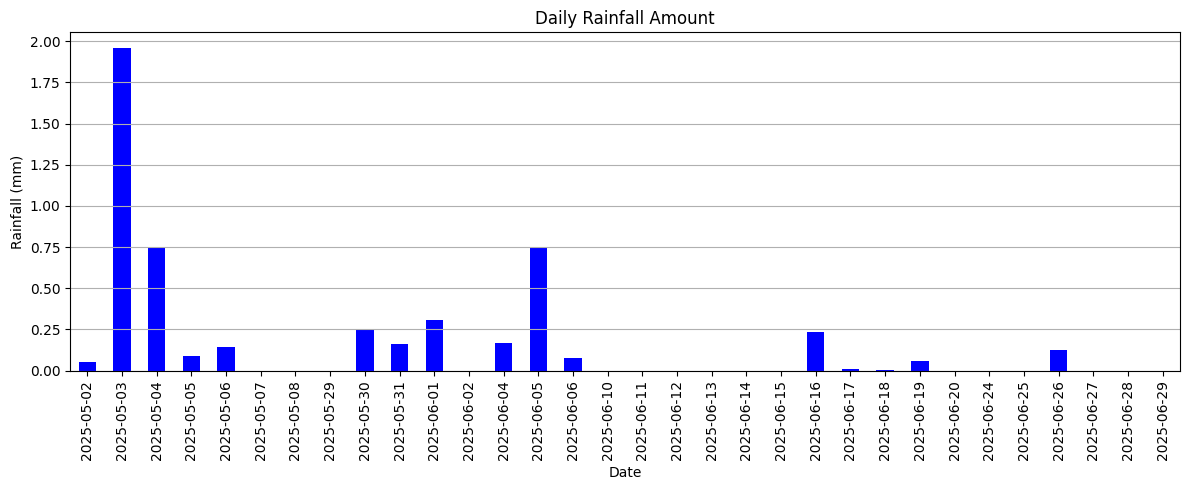

In [183]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results_daily['date'] = pd.to_datetime(df_results_daily['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results_daily.groupby('date')['rain_mean'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [184]:
df_final_for_analysis[df_final_for_analysis["predicted_risk"] == "Critical"]

,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,label,anomaly_score,anomaly_score_shifted_for_prediction,predicted_risk,true_label
31694.0,2025-05-03 01:39:00,102,52.375000,15.506700,26.789787,80.952106,18.003582,Normal,3.731224,3.731224,Critical,Normal
31695.0,2025-05-03 01:40:00,102,51.240000,16.987520,26.805676,80.786069,15.676766,Normal,4.158795,4.158795,Critical,Normal
31696.0,2025-05-03 01:41:00,102,51.420000,18.384520,26.789120,80.882965,15.898906,Normal,3.921869,3.921869,Critical,Normal
31697.0,2025-05-03 01:42:00,102,50.620000,19.502121,26.841993,80.484706,15.791709,Normal,3.344837,3.344837,Critical,Normal
822.0,2025-05-03 01:53:00,101,55.719999,14.137640,25.868925,81.769133,18.898269,Normal,3.294742,3.294742,Critical,Normal
823.0,2025-05-03 01:54:00,101,55.633332,14.947900,25.969330,81.364577,20.773781,Normal,4.194174,4.194174,Critical,Normal
824.0,2025-05-03 01:55:00,101,55.639999,15.311120,26.200046,80.475166,17.836158,Normal,5.078063,5.078063,Critical,Normal
825.0,2025-05-03 01:56:00,101,55.599998,15.646400,25.882811,82.065540,17.046588,Normal,5.472074,5.472074,Critical,Normal
826.0,2025-05-03 01:57:00,101,55.520000,15.646400,25.840086,82.025865,24.436731,Normal,5.153119,5.153119,Critical,Normal
827.0,2025-05-03 01:58:00,101,55.400002,15.646400,26.211261,80.257344,21.577497,Normal,4.525288,4.525288,Critical,Normal
